# Sentiment Analysis of Amazon's Customer Reviews Applying<br> NLP (Natural Language Processing)

### <a id='Importing-Packages'>3. Importing Packages</a>

In [103]:
# ! pip install nltk
# ! pip install wordcloud

In [2]:
# General packages
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import os

# NLP packages
import nltk  # the most famous python module for NLP techniques
from nltk import word_tokenize
from nltk.tokenize import word_tokenize
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from collections import Counter
from wordcloud import WordCloud # to express the words in a word cloud (words review visualization)

# Modeling packages
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from sklearn.svm import LinearSVC
from sklearn.metrics import classification_report

from pylab import rcParams
import warnings
warnings.filterwarnings("ignore")
rcParams['figure.figsize'] = 14, 6
plt.style.use('ggplot')

### <a id='Importing-Data'>4. Importing Data</a>

In [3]:
# Reading data from .csv file
amazon_ProRev = pd.read_csv('Amazon Product Reviews.csv')
amazon_ProRev.head(4)

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,5,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,1,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,4,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...
3,4,B000UA0QIQ,A395BORC6FGVXV,Karl,3,3,2,1307923200,Cough Medicine,If you are looking for the secret ingredient i...


Performing some basic exploratory data analysis to analyze the frequency of the words in each of the reviews. Accessing the text and applying a lambda function to split the text by the spaces of the reviews and getting the words followed by counting the words per review. Drawing the words into a histogram.

Let's look at the distribution of the number of words per review.

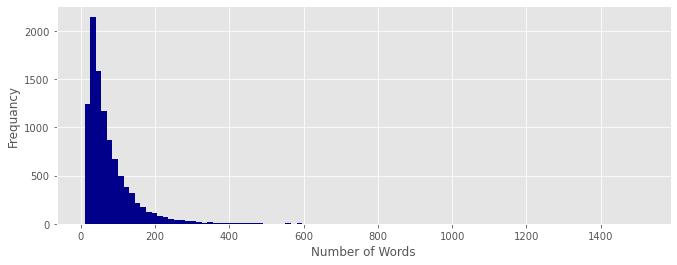

In [4]:
# Getting the number of words by splitting them by a space
numof_words_per_review = amazon_ProRev.Text.apply(lambda x: len(x.split(" ")))
numof_words_per_review.hist(bins=100, color='darkblue', figsize=(11, 4))
plt.xlabel('Number of Words')
plt.ylabel('Frequancy')
plt.show()

In [5]:
print('Average words:', numof_words_per_review.mean())
print('Skewness:', numof_words_per_review.skew())

Average words: 77.89078907890789
Skewness: 4.614095350750607


The graph is positively skewed and shows almost all the reviews have less than 200 words that is very important for us because, to analyze the reviews we need to know how this dimensional space is looking like (200 words per review as maximum and 77 words as average review).

Let's also look at the distribution of ratings (scores).

In [6]:
# calculating the rating percentage
rating_percentVal = 100* amazon_ProRev['Score'].value_counts()/len(amazon_ProRev)
rating_percentVal

5    61.836184
4    14.321432
1     9.320932
3     8.620862
2     5.900590
Name: Score, dtype: float64

Looking at the results, 61.8% of reviews have 5 stars, 14.3% have 4 stars, 8.6% have 3 stars, 5.9% have 2 stars and 9.3% have 1 star.

To have better visualization these percentages were shown in the bar graph.

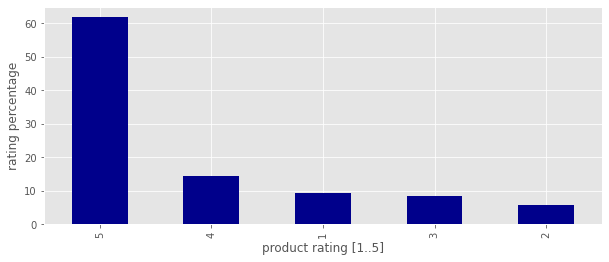

In [7]:
# scores distribution
rating_percentVal.plot.bar(figsize=(10,4), color='darkblue')
plt.xlabel('product rating [1..5]')
plt.ylabel('rating percentage')
plt.show()

The distribution is quite skewed, with a large number of 5s and very few 3s, 2s, and 1s.

### <a id='Data-Visualization'>5. Data Visualization using Word Cloud</a> 

Word cloud lets us visualize what the distribution of the text looks like. If the frequency of the word in all the reviews is high, the word appears large and if it's low the word appears small.

Visualization is crucial for numerical data and also important for the text data. However, the text does not lend itself to histogram charts or scatterplots, as numerical data does. In such cases, the word clouds are a common and very useful tool to appreciate the text distribution.

To make a word cloud of the string values of the text data, we are going to import the **WordCloud** package (install it with pip install wordcloud) and join all the text with the **.join()** method.

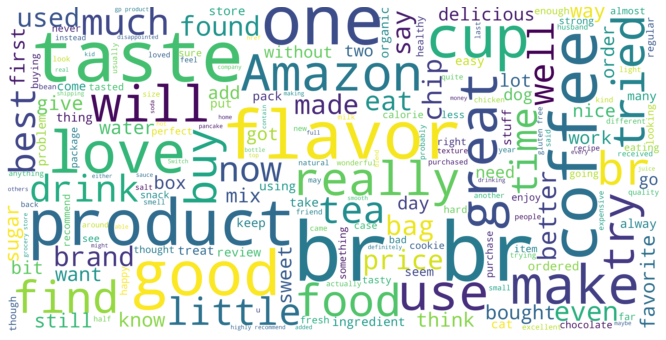

In [8]:
# Joining all the reviews from dataset in a general string 
text_word_cloud = ''.join(amazon_ProRev['Text'])

# generating word cloud using WordCloud package and generate() function 
wc = WordCloud(max_font_size=100, # Maximum font size for the largest word
               max_words=200, # Maximum number of words
               background_color="white", # background color of the word cloud image
               scale=10, # Scaling between computation and drawing
               width=800, # Width of the canvas
               height=400 # Height of the canvas 
              ).generate(text_word_cloud)

plt.figure()
plt.imshow(wc, interpolation="bilinear") # to make the displayed image appear more smoothly
plt.axis("off")
plt.show()

As a distribution of the text, the above word cloud shows that the most of reviews are indeed related to the food:"delicious", "flavor", "food", "taste", "coffee", "tea", etc. <br>
Some words are related to the customer experience with the food: "good", "love", "best", and some are not desired ones such as "br" (line break), "many" (determiner) and "something" (adverb), which might not give us any insights about the reviews. So, we need to use the techniques to delete or drop these words.

In [9]:
# Splitting text into word
reviews = amazon_ProRev['Text'].str.cat(sep=' ')

#function to split text into word
tokens = word_tokenize(reviews)
vocabulary = set(tokens)
print(len(vocabulary))

frequency_dist = nltk.FreqDist(tokens)
#sorted(frequency_dist,key=frequency_dist.__getitem__, reverse=True)[0:50]

29399


### <a id='Data-Prepration'>6. Data Prepration</a><br>

The most important step to analyze the data, is to clean and prepare the dataset. A good model is not only dependent on the algorithm, but on a clean dataset mostly. There are many tactics in Text Data Processing, such as:
- Remove non-alphanumeric characters, except for white space.
- Convert all characters to lowercase, in order to treat the words such as “Hello”, “hello”, “HELLO”, “HEllO” all the same.
- Consider Tokenization, Stemming, and lemmatization.
- and so on.<br>

In addition to a clean dataset, since machine learning models always take numeric values as input, we need to represent text as a vector of “number” to satisfy the requirement.

In order to have a sentiment analysis we start with performing data preparation. 

### <a id='Standardization-the-Ratings'>6.1. Standardization the Ratings</a> 

For the purposes of sentiment analysis, we will convert all of the ratings into binary values using the following rule:

- Ratings of 4 or 5 will get mapped to 1 and will be related to positive reviews.
- Ratings of 1 or 2 will get mapped to 0 and will be related to negative reviews.
- Ratings of 3 will get removed since they will represent neutral reviews.

We can achieve these mappings by using **.where()** function which filters the rating values to 0 and 1. If the score is greater than 3 it will represent as 1, otherwise represent as 0.

In [10]:
# Mapping the ratings
amazon_ProRev['Sentiment_rating'] = np.where(amazon_ProRev.Score > 3,1,0)

# Removing neutral reviews. 
# We don't consider the 3 ratings which represents the neutral reviews, only positive(1) and negetive(0) will be analyzed.
amazon_ProRev = amazon_ProRev[amazon_ProRev.Score != 3]

# Printing the counts of each class
amazon_ProRev['Sentiment_rating'].value_counts()

1    7615
0    1522
Name: Sentiment_rating, dtype: int64

Looking at the results, showing that most of the reviews are positive.

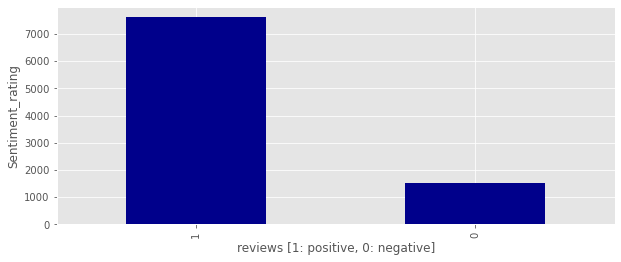

In [11]:
# ploting the distribution of the number of positive and negative reviews
amazon_ProRev.Sentiment_rating.value_counts().plot.bar(figsize=(10,4), color='darkblue')
plt.xlabel('reviews [1: positive, 0: negative]')
plt.ylabel('Sentiment_rating')
plt.show()


There is a class imbalance that we are going to handle by defining robust metrics as the f1 score.

### <a id='Data-Pre-processing'>6.2. Data Pre-processing</a> 


Text preprocessing and normalization is crucial before building a proper NLP model. Some of the important steps are:

- Converting words to lower/upper case
- Removing special characters
- Removing stopwords and high/low-frequency words
- Stemming/lemmatization

**1. Converting words to lower/upper case**

We start by converting all of the words into a consistent case format, say lowercase by using **.lower()** function.

In [12]:
# Converting text reviews to lowercase using lower() function
amazon_ProRev['lowercase_text_reviews'] = amazon_ProRev['Text'].str.lower()
print(amazon_ProRev['lowercase_text_reviews'][6])

this saltwater taffy had great flavors and was very soft and chewy.  each candy was individually wrapped well.  none of the candies were stuck together, which did happen in the expensive version, fralinger's.  would highly recommend this candy!  i served it at a beach-themed party and everyone loved it!


In the following code we analyze the number of unique words that are found in reviews. This process of extracting individual words is called word tokenization, and can be run using the **.word_tokenize()** function from nltk package.

In [13]:
from nltk import word_tokenize

# Word tokenization example:
word_tokenize("this saltwater taffy had great flavors and was very soft and chewy. :D")

['this',
 'saltwater',
 'taffy',
 'had',
 'great',
 'flavors',
 'and',
 'was',
 'very',
 'soft',
 'and',
 'chewy',
 '.',
 ':',
 'D']

In [14]:
# Number of tokens before converting reviews to lowercase
token_lists = [word_tokenize(each) for each in amazon_ProRev['Text']]
tokens = [item for sublist in token_lists for item in sublist]
print("Number of unique tokens then: ",len(set(tokens)))

# Number of tokens after converting reviews to lowercase
token_lists_lower = [word_tokenize(each) for each in amazon_ProRev['lowercase_text_reviews']]
tokens_lower = [item for sublist in token_lists_lower for item in sublist]
print("Number of unique tokens now: ",len(set(tokens_lower)))

Number of unique tokens then:  27881
Number of unique tokens now:  22850


The result shows that the number of tokens has gone down by ~18% by converting the tokens to the lowercase from normalizing the corpus. So we reduced the bias by applying the lowercase transformation to the words and expressed all the words in a standard and normalized way (lowercase).

**2. Removing special characters**

After we transformed the text into lowercase we remove some special characters that aren't going to give us insights. 

The following gives a list of all the special characters in our dataset by applying **.isalnum()** function.

In [15]:
# Selecting non alpha numeric charactes that are not spaces using isalnum() function
spl_chars = amazon_ProRev['lowercase_text_reviews'].apply(lambda review: 
                                                     [char for char in list(review) if not char.isalnum() and char != ' '])

# Getting list of list into a single list
flat_list = [item for sublist in spl_chars for item in sublist]

# Unique special characters
#set(flat_list)

Now we remove these special characters from the reviews by applying a regular expression and using **.replace()** function.

Removing special characters is a subjective call, especially in cases like this one. People often use special characters to express their emotions and might leave a review like 'This product is the worst!!!', while a positive review could be like 'This product is the best. Loved it!'. Here, the presence of exclamation marks clearly indicates something about the underlying sentiment, so removing them may well not be a good idea.

On the other hand, removing non-emotionally charged punctuation such as commas, periods, and semicolons is likely safe.

In [16]:
# removing the special characters 
review_copy = amazon_ProRev['lowercase_text_reviews'].copy()
amazon_ProRev['lowercase_text_reviews'] = amazon_ProRev['lowercase_text_reviews'].str.replace(r'[^A-Za-z0-9 ]+', ' ')

In the regular expression [^A-Za-z0-9 ]+:

- [ ]: match any character inside the list defined by the square brackets, including the space character ' '
- ^: start of the line
- A-Z: accept english upper case characters from A to Z
- a-z: accept english lower case characters from a to z
- 0-9: accept single number characters from 0 to 9


We can see how our reviews change after removing these characters.

In [17]:
print("-- Old Review --")
print(review_copy.values[6])
print("\n-- New Review --")
print(amazon_ProRev['lowercase_text_reviews'][6])

-- Old Review --
this saltwater taffy had great flavors and was very soft and chewy.  each candy was individually wrapped well.  none of the candies were stuck together, which did happen in the expensive version, fralinger's.  would highly recommend this candy!  i served it at a beach-themed party and everyone loved it!

-- New Review --
this saltwater taffy had great flavors and was very soft and chewy   each candy was individually wrapped well   none of the candies were stuck together  which did happen in the expensive version  fralinger s   would highly recommend this candy   i served it at a beach themed party and everyone loved it 


As we can see in previous reviews we have all special characters and in the new reviews all were dropped and replaced with space, so the new reviews are going to be the reviews to be analyzed.

In [18]:
token_lists = [word_tokenize(each) for each in amazon_ProRev['Text']]
tokens = [item for sublist in token_lists for item in sublist]
print("Number of unique tokens then: ",len(set(tokens)))

token_lists = [word_tokenize(each) for each in amazon_ProRev['lowercase_text_reviews']]
tokens = [item for sublist in token_lists for item in sublist]
print("Number of unique tokens now: ",len(set(tokens)))

Number of unique tokens then:  27881
Number of unique tokens now:  18037


So, the number of tokens dropped to 18037 after removing the special characters from the reviews.

**3. Stopwords and high/low frequency words**<br>

Stopwords naturally occur very frequently in the English language without adding any specific insights and it makes sense to remove them. Here are the list of languages are available in the nltk package.

In [19]:
from nltk.corpus import stopwords

print('All Languages in NLTK: \n')
print(stopwords.fileids())

All Languages in NLTK: 

['arabic', 'azerbaijani', 'danish', 'dutch', 'english', 'finnish', 'french', 'german', 'greek', 'hungarian', 'indonesian', 'italian', 'kazakh', 'nepali', 'norwegian', 'portuguese', 'romanian', 'russian', 'slovene', 'spanish', 'swedish', 'tajik', 'turkish']


Some languages are not included in this package, but there are other packages like inltk to process reviews in different languages. 

Let's now review the list of English stopwords. These stopwords are not giving us much insight about the review, so we might want to discard these words.

In [20]:
noise_words = []
eng_stop_words = stopwords.words('english')
#eng_stop_words

Now we remove these stopwords from the reviews. To do this, we tokenize the reviews and add the tokens into seperate lists (stopword and none-stopword).

In [21]:
# seperating stopwords and non-stopwords from the reviews
stop_words = set(eng_stop_words)
del_stop_words = []
stopword = []

# using review number 0 as an example
sentence = amazon_ProRev['lowercase_text_reviews'][0] 

# tokenize a sentence to the seperate tokens
words = nltk.word_tokenize(sentence)

# Adding words into different array, stopwords and without stopwords(del_stop_words)
for word in words:
    if word in stop_words:
        stopword.append(word)
    else:
        del_stop_words.append(word)
        
print('-- Original Sentence --\n', sentence)
print('\n-- Stopwords in the sentence --\n', stopword)
print('\n-- Non-stopwords in the sentence --\n', del_stop_words)

-- Original Sentence --
 i have bought several of the vitality canned dog food products and have found them all to be of good quality  the product looks more like a stew than a processed meat and it smells better  my labrador is finicky and she appreciates this product better than  most 

-- Stopwords in the sentence --
 ['i', 'have', 'of', 'the', 'and', 'have', 'them', 'all', 'to', 'be', 'of', 'the', 'more', 'a', 'than', 'a', 'and', 'it', 'my', 'is', 'and', 'she', 'this', 'than', 'most']

-- Non-stopwords in the sentence --
 ['bought', 'several', 'vitality', 'canned', 'dog', 'food', 'products', 'found', 'good', 'quality', 'product', 'looks', 'like', 'stew', 'processed', 'meat', 'smells', 'better', 'labrador', 'finicky', 'appreciates', 'product', 'better']


Now, we use reviews without stopwords for analyzing the words since they give us the insight. To delete the stopwords we define **.remove_stopwords()** function to return a list of non-stopwords of all the reviews.

In [22]:
def remove_stopwords(stop_words, sentence):
    return [word for word in nltk.word_tokenize(sentence) if word not in stop_words]

amazon_ProRev['withoutstop_reviews_text'] = amazon_ProRev['lowercase_text_reviews'].apply(lambda row: remove_stopwords(stop_words, row))
amazon_ProRev[['lowercase_text_reviews','withoutstop_reviews_text']]

,lowercase_text_reviews,withoutstop_reviews_text
0,i have bought several of the vitality canned d...,"[bought, several, vitality, canned, dog, food,..."
1,product arrived labeled as jumbo salted peanut...,"[product, arrived, labeled, jumbo, salted, pea..."
2,this is a confection that has been around a fe...,"[confection, around, centuries, light, pillowy..."
3,if you are looking for the secret ingredient i...,"[looking, secret, ingredient, robitussin, beli..."
4,great taffy at a great price there was a wid...,"[great, taffy, great, price, wide, assortment,..."
...,...,...
9994,i switched from similac advanced to organic wh...,"[switched, similac, advanced, organic, daughte..."
9995,we switched from the advance similac to the or...,"[switched, advance, similac, organic, product,..."
9996,like the bad reviews say the organic formula ...,"[like, bad, reviews, say, organic, formula, co..."
9997,i wanted to solely breastfeed but was unable t...,"[wanted, solely, breastfeed, unable, keep, sup..."


**4. Stemming & lemmatization**<br>

Now we are ready for the last part of our pre-processing - stemming & lemmatization.

**Stemming** is the process of reducing inflection in words to their root forms such as mapping a group of words to the same stem even if the stem itself is not a valid word in the Language. It works by cutting off the end or the beginning of the word, taking into account a list of common prefixes and suffixes that can be found.

**Lemmatization** takes into consideration the morphological analysis of the words. So lemmatization considers the grammar of the word and tries to find the root word instead of just getting to the root word by brute force methods.

In [23]:
from nltk.stem import PorterStemmer, LancasterStemmer # Common Stemmers
from nltk.stem import WordNetLemmatizer # Common Lemmatizer
nltk.download('wordnet')
from nltk.corpus import wordnet

porter = PorterStemmer()
lancaster = LancasterStemmer()
lemmatizer = WordNetLemmatizer()

[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\Soheila\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [24]:
# defining stemSentence() function to do data stemming
from nltk.stem.porter import *
stemmer = PorterStemmer()

def stemSentence(sentence):
    token_words=word_tokenize(sentence)
    token_words
    stem_sentence=[]
    for word in token_words:
        stem_sentence.append(porter.stem(word))
        stem_sentence.append(" ")
    return "".join(stem_sentence)
#df['stemmed'] = df['unstemmed'].apply(lambda x: [stemmer.stem(y) for y in x]) 
amazon_ProRev['stemmed_reviews_text'] = amazon_ProRev['withoutstop_reviews_text'].apply(lambda x: [stemSentence(y) for y in x])
amazon_ProRev[['withoutstop_reviews_text','stemmed_reviews_text']]

,withoutstop_reviews_text,stemmed_reviews_text
0,"[bought, several, vitality, canned, dog, food,...","[bought , sever , vital , can , dog , food , p..."
1,"[product, arrived, labeled, jumbo, salted, pea...","[product , arriv , label , jumbo , salt , pean..."
2,"[confection, around, centuries, light, pillowy...","[confect , around , centuri , light , pillowi ..."
3,"[looking, secret, ingredient, robitussin, beli...","[look , secret , ingredi , robitussin , believ..."
4,"[great, taffy, great, price, wide, assortment,...","[great , taffi , great , price , wide , assort..."
...,...,...
9994,"[switched, similac, advanced, organic, daughte...","[switch , similac , advanc , organ , daughter ..."
9995,"[switched, advance, similac, organic, product,...","[switch , advanc , similac , organ , product ,..."
9996,"[like, bad, reviews, say, organic, formula, co...","[like , bad , review , say , organ , formula ,..."
9997,"[wanted, solely, breastfeed, unable, keep, sup...","[want , sole , breastfe , unabl , keep , suppl..."


In [25]:
# defining lemmSentence() function to do data lemmatization 
def lemmSentence(sentence):
    token_words=word_tokenize(sentence)
    token_words
    lemma_sentence=[]
    for word in token_words:
        lemma_sentence.append(lemmatizer.lemmatize(word, pos="v"))
        lemma_sentence.append(" ")
    return "".join(lemma_sentence)

amazon_ProRev['lemma_reviews_text'] = amazon_ProRev['withoutstop_reviews_text'].apply(lambda x: [lemmSentence(y) for y in x])
amazon_ProRev[['withoutstop_reviews_text','lemma_reviews_text']]

,withoutstop_reviews_text,lemma_reviews_text
0,"[bought, several, vitality, canned, dog, food,...","[buy , several , vitality , can , dog , food ,..."
1,"[product, arrived, labeled, jumbo, salted, pea...","[product , arrive , label , jumbo , salt , pea..."
2,"[confection, around, centuries, light, pillowy...","[confection , around , centuries , light , pil..."
3,"[looking, secret, ingredient, robitussin, beli...","[look , secret , ingredient , robitussin , bel..."
4,"[great, taffy, great, price, wide, assortment,...","[great , taffy , great , price , wide , assort..."
...,...,...
9994,"[switched, similac, advanced, organic, daughte...","[switch , similac , advance , organic , daught..."
9995,"[switched, advance, similac, organic, product,...","[switch , advance , similac , organic , produc..."
9996,"[like, bad, reviews, say, organic, formula, co...","[like , bad , review , say , organic , formula..."
9997,"[wanted, solely, breastfeed, unable, keep, sup...","[want , solely , breastfeed , unable , keep , ..."


Once we have applied these four-step exploratory data analysis procedures, including, transforme the reviews to the lowercase, deleted the special characters, removed the stopwords and stemmed and lammetized the text we can go to the modeling stage.

### <a id='Building-a-Machine-Learning-model'>7.  Building a Machine Learning Model</a> 

We have already done the exploratory data analysis and now we can go to the modeling stage. This is a supervised learning analysis as we have the target variable and we are going to apply some classification models into this target variable.

Now we have cleaned-up versions of two very important pieces of data – the actual review text and its corresponding sentiment rating.

In [26]:
amazon_ProRev[['Text','Score','Sentiment_rating']].head(5)

,Text,Score,Sentiment_rating
0,I have bought several of the Vitality canned d...,5,1
1,Product arrived labeled as Jumbo Salted Peanut...,1,0
2,This is a confection that has been around a fe...,4,1
3,If you are looking for the secret ingredient i...,2,0
4,Great taffy at a great price. There was a wid...,5,1


To have additional insights of the reviews we can analyze words together by using n-grams to create features.
For this reason, it is often prudent to start by extracting as much value out of 1-grams as possible, before working our way up to more complex structures.
ngrams are going to give you more context, but also are going to give more computational expense.

Let's look at an example of extracting n-grams over a proposed sentence.

In [27]:
# n-gram modeling example:
from nltk import ngrams

sentence = 'this saltwater taffy had great flavors and was very soft and chewy. :D'

for n in range(1, 6):
    print(str(n) + '-grams:\n', list(ngrams(sentence.split(), n)), '\n')

1-grams:
 [('this',), ('saltwater',), ('taffy',), ('had',), ('great',), ('flavors',), ('and',), ('was',), ('very',), ('soft',), ('and',), ('chewy.',), (':D',)] 

2-grams:
 [('this', 'saltwater'), ('saltwater', 'taffy'), ('taffy', 'had'), ('had', 'great'), ('great', 'flavors'), ('flavors', 'and'), ('and', 'was'), ('was', 'very'), ('very', 'soft'), ('soft', 'and'), ('and', 'chewy.'), ('chewy.', ':D')] 

3-grams:
 [('this', 'saltwater', 'taffy'), ('saltwater', 'taffy', 'had'), ('taffy', 'had', 'great'), ('had', 'great', 'flavors'), ('great', 'flavors', 'and'), ('flavors', 'and', 'was'), ('and', 'was', 'very'), ('was', 'very', 'soft'), ('very', 'soft', 'and'), ('soft', 'and', 'chewy.'), ('and', 'chewy.', ':D')] 

4-grams:
 [('this', 'saltwater', 'taffy', 'had'), ('saltwater', 'taffy', 'had', 'great'), ('taffy', 'had', 'great', 'flavors'), ('had', 'great', 'flavors', 'and'), ('great', 'flavors', 'and', 'was'), ('flavors', 'and', 'was', 'very'), ('and', 'was', 'very', 'soft'), ('was', 'very'

### <a id='Bag-of-Words-Model'>7.1.  Bag of Words Model</a> 

The bag-of-words procedure falls under a broader category of techniques known as **count-based representations**. These are techniques to analyze documents by indicating how frequently certain types of structures occur throughout.

Here we create a word-document co-occurrence matrix for our set of reviews using the **CountVectorizer** class that automatically accounts for certain preprocessing steps like removing stopwords, stemming, creating n-grams, and word tokenization.

In [28]:
amazon_ProRev['lowercase_text_reviews'][10]

'i don t know if it s the cactus or the tequila or just the unique combination of ingredients  but the flavour of this hot sauce makes it one of a kind   we picked up a bottle once on a trip we were on and brought it back home with us and were totally blown away   when we realized that we simply couldn t find it anywhere in our city we were bummed br  br  now  because of the magic of the internet  we have a case of the sauce and are ecstatic because of it br  br  if you love hot sauce i mean really love hot sauce  but don t want a sauce that tastelessly burns your throat  grab a bottle of tequila picante gourmet de inclan   just realize that once you taste it  you will never want to use any other sauce br  br  thank you for the personal  incredible service '

To create word-document matrix and convert the reviews to a matrix of token counts **.vec.fit_transform()** function was used.

In [29]:
# creating word-document matrix
from sklearn.feature_extraction.text import CountVectorizer

# converting reviews to a matrix of token counts
vec = CountVectorizer()
X = vec.fit_transform(amazon_ProRev['lowercase_text_reviews'])
df = pd.DataFrame(X.toarray(), columns = vec.get_feature_names())
df.head()

,00,000,0003,000kwh,002,008,0100,0174,02,03,...,zomg,zon,zoo,zoom,zotz,zucchini,zuke,zukes,zupas,zuppa
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


This is the matrix of words including all reviews as rows and each unique word as column. So, each word in the review is going to be counted on each of the reviews. 

Now we use this to create a bag of words from the reviews, excluding the noise words we identified earlier.

In [30]:
# Creating a python object of the class CountVectorizer
bagofwords_counts = CountVectorizer(tokenizer= word_tokenize, # type of tokenization
                                    stop_words=noise_words, # List of stopwords
                                    ngram_range=(1,1)) # number of n-grams

# Fitting and transforming the reviews 
bagofwords_data = bagofwords_counts.fit_transform(amazon_ProRev['lowercase_text_reviews'])
bagofwords_data

<9137x18037 sparse matrix of type '<class 'numpy.int64'>'
	with 493328 stored elements in Compressed Sparse Row format>

We can see that a sparse matrix of 9137 observations (number of rows of the reviews_text_new series) has been built, and 18037 columns (words) corresponding to the features extracted by means of the representation of the 1-gram count of the user reviews, which is very difficult to process and computationally expensive.

Since this matrix includes numerical data (counts of the words) we can have featurized approach where each of the columns is one feature and rows are the observations.

### <a id='Applying-Logistic-Regression-to-Bag-of-Words-Features'>7.1.1.  Applying Logistic Regression to Bag of Words Features</a> 

Once the bag of words is prepared, to model the dataset, we divide the data into training and testing sets (20%). Here the target variable is the "Sentiment_rating" that has been already defined.

In [31]:
X_train_bagofwords, X_test_bagofwords, y_train_bagofwords, y_test_bagofwords = train_test_split(bagofwords_data, # Features
                                                                    amazon_ProRev['Sentiment_rating'], # Target variable
                                                                    test_size = 0.2, # 20% test size
                                                                    random_state = 0) # random state for replication purposes

In [32]:
y_test_bagofwords.value_counts()/y_test_bagofwords.shape[0]

1    0.845186
0    0.154814
Name: Sentiment_rating, dtype: float64

The test data contains 84.5% positive sentiment reviews. So, if we were to classify all reviews as positive, then our model would achieve an accuracy of 84.5%. Therefore, this is the baseline that any model we create must beat. We have an imbalance in the classes. However, we will skip the handling class imbalance processes to focus on NLP modeling. As an intermediate step, techniques such as SMOTE, sub-sampling or oversampling can be applied.

Let's train the model on our training data and run the resulting model on our test data.

In [33]:
# Training the model 
lr_model_all = LogisticRegression() # Logistic regression
lr_model_all.fit(X_train_bagofwords, y_train_bagofwords) # Fitting a logistic regression model

# Predicting the output
test_pred_lr_all = lr_model_all.predict(X_test_bagofwords) # Class prediction

# Calculate key performance metrics
print("f1 score: ", f1_score(y_test_bagofwords, test_pred_lr_all))

f1 score:  0.9506726457399103


As we can see the f1 score is 95.0% which is considerably high.

Instead of counting words we can count by bigrams, trigrams, and 4-grams, modifying the set of features in the model to include them and applying the same approach.

In [34]:
# Changes with respect to the previous code
# 1. Increasing the n-grams from just having 1-gram to (2-gram, 3-gram, and 4-gram) 
# 2. Including the stopwords in the bag of words features

# using 3-gram
bagofwords_counts = CountVectorizer(tokenizer= word_tokenize,
                             ngram_range=(1,3))

bagofwords_data = bagofwords_counts.fit_transform(amazon_ProRev.lowercase_text_reviews)

In [35]:
# Notice the increase in features with inclusion of n-grams
bagofwords_data

<9137x672436 sparse matrix of type '<class 'numpy.int64'>'
	with 1848991 stored elements in Compressed Sparse Row format>

As we can see by increasing the number of grams, the number of features and the number of computational expenses increases.

Now, we split the dataset to the training and testing sets again and apply Logistic Regression method to predict the f1 score.

In [36]:
X_train_bagofwords, X_test_bagofwords, y_train_bagofwords, y_test_bagofwords = train_test_split(bagofwords_data,
                                                                    amazon_ProRev['Sentiment_rating'],
                                                                    test_size = 0.2,
                                                                    random_state = 0)

In [37]:
import sklearn.linear_model as lm

# Defining and training the model
lr_model_all_new = lm.LogisticRegression(max_iter = 200)
lr_model_all_new.fit(X_train_bagofwords, y_train_bagofwords)

# Predicting the results
test_pred_lr_all = lr_model_all_new.predict(X_test_bagofwords)

print("f1 score: ", f1_score(y_test_bagofwords,test_pred_lr_all))

f1 score:  0.9528301886792453


The f1 score has increased slightly from 95.0% to 95.2%. So, we have to balance our computational expenses from coming of 18037 features to 672436 against 0.2% of increase in our f1 score. 

This is an example of what simple hyperparameter tuning and input feature modification can do to the overall performance. We can even get interpretable features from this in terms of what contributed the most to positive and negative sentiment.

We want to extract which are the most important words for the classifier in order to classify the reviews into positive and negatives.

In [38]:
lr_weights = pd.DataFrame(list(zip(bagofwords_counts.get_feature_names(), # get all the n-gram feature names
                                   lr_model_all_new.coef_[0])), # get the logistic regression coefficients
                                   columns= ['words','weights']) # defining the colunm names

lr_weights.sort_values(['weights'], ascending = False)[:15] # top-15 more important features for positive reviews

,words,weights
244664,great,1.383331
164900,delicious,1.069454
432285,perfect,0.951251
194869,excellent,0.917916
553179,the best,0.882132
239228,good,0.846291
377902,nice,0.844922
90001,best,0.831292
338387,love,0.801611
340055,loves,0.754168


Here are the 15 top words for the classifier to classify into positive reviews. So, words such as "great", "delicious", "perfect", good", the best", ... are driving the classifier to classify the entire review into a positive review, as well as the negative reviews that have words such as "worst", "very disappointed", "awful", "bad", ... and driving the classifier to classify the review to the negative.

In [39]:
lr_weights.sort_values(['weights'], ascending = False)[-15:] # top-15 more important features for negative reviews

,words,weights
269694,horrible,-0.595227
74544,away,-0.627882
532429,t,-0.638263
662458,worst,-0.644900
627977,very disappointed,-0.647815
469779,return,-0.660036
637501,waste,-0.678733
75097,awful,-0.712154
519029,stick,-0.724655
171623,disappointing,-0.744972


### <a id='Applying-Linear-Support-Vector-Machine-(SVM)-to-Bag-of-Words-Features'>7.1.2.  Applying Linear Support Vector Machine (SVM) to Bag of Words Features</a>  

Now, we train the model on our training data and run the resulting model on our test data using SVM method.

In [40]:
# Defining and training the model
clf_model_all_new = LinearSVC()
clf_model_all_new.fit(X_train_bagofwords, y_train_bagofwords)

LinearSVC(C=1.0, class_weight=None, dual=True, fit_intercept=True,
          intercept_scaling=1, loss='squared_hinge', max_iter=1000,
          multi_class='ovr', penalty='l2', random_state=None, tol=0.0001,
          verbose=0)

In [41]:
test_pred_clf_all = clf_model_all_new.predict(X_test_bagofwords)

print("f1 score: ", f1_score(y_test_bagofwords,test_pred_clf_all))

f1 score:  0.9564668769716089


Looking at result, shows that the f1 score is 95.6% which is considerably high.

Comparing the f1 scores of LR and SVM models shows that the accuracy of the SVM with the value of 95.6% is higher than LR with the value of 95.2%. 

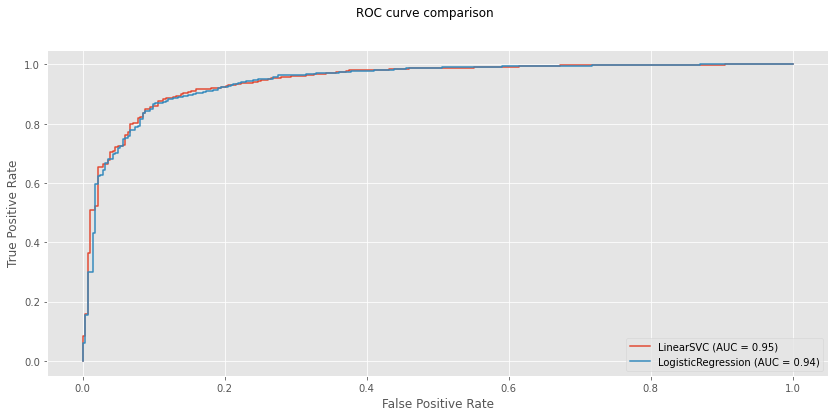

<Figure size 288x432 with 0 Axes>

In [42]:
import matplotlib.pyplot as plt  
from sklearn import datasets, metrics, model_selection, svm


clf_model_all_new.fit(X_train_bagofwords, y_train_bagofwords)

clf_disp = metrics.plot_roc_curve(clf_model_all_new, X_test_bagofwords, y_test_bagofwords)  
log_disp = metrics.plot_roc_curve(lr_model_all_new, X_test_bagofwords, y_test_bagofwords, ax = clf_disp.ax_)  

clf_disp.figure_.suptitle("ROC curve comparison")
plt.figure(figsize=(4,6))
plt.show()

ROC Curve comparison shows that the area under curve for SVC Classifier (0.95) is slighty bigger than LR (0.94), so it has higher performance.

### <a id='TF-IDF-Model'>7.2. TF-IDF Model</a> 

Bag-of-words are not the only way to featurize text. Another method is the **Term Frequency-Inverse Document Frequency (TF-IDF)** method. This method evaluates how important a word is to a document within a large collection of documents (i.e. corpus). The importance increases proportionally based on the number of times a word appears in the document but is offset by the frequency of the word in the corpus.

Now, we re-featurize our original set of reviews based on TF-IDF and split the resulting features into train and test sets.

In [43]:
# implementing tf-idf model
from sklearn.feature_extraction.text import TfidfVectorizer

# Creating a python object of the class CountVectorizer
tfidf_counts = TfidfVectorizer(tokenizer= word_tokenize, # type of tokenization
                               stop_words=noise_words, # List of stopwords
                               ngram_range=(1,1)) # number of n-grams

tfidf_data = tfidf_counts.fit_transform(amazon_ProRev['lowercase_text_reviews'])

In [44]:
tfidf_data

<9137x18037 sparse matrix of type '<class 'numpy.float64'>'
	with 493328 stored elements in Compressed Sparse Row format>

Here we have the same number of features/columns as bag of words model since we were applying the same approach of counting times a logarithm value. 

### <a id='Applying-Logistic-Regression-to-TF-IDF-Features'>7.2.1. Applying Logistic Regression to TF-IDF Features</a> 

In [45]:
X_train_tfidf, X_test_tfidf, y_train_tfidf, y_test_tfidf = train_test_split(tfidf_data,
                                                                            amazon_ProRev['Sentiment_rating'],
                                                                            test_size = 0.3,
                                                                            random_state = 0)

Now, we test the model using the f1 score by applying Logistic Regression to the features created from TF-IDF.

In [46]:
# Setting up the model class
lr_model_tf_idf = LogisticRegression()

# Training the model 
lr_model_tf_idf.fit(X_train_tfidf,y_train_tfidf)

# Prediciting the results
test_pred_lr_all = lr_model_tf_idf.predict(X_test_tfidf)

# Evaluating the model
#print("F1 score: ",f1_score(y_test_bagofwords, test_pred_lr_all))
print("f1 score: ",f1_score(y_test_tfidf, test_pred_lr_all))

f1 score:  0.9361354825545806


Comparing the f1 scores, using Linear Regression model for Bag of Words and TF-IDF features shows that this score for TF_IDF with the value of 93.6% is less than BOW with the value of 95%. Sometimes this happens and sometimes TF-IDF is a better approach, so we have to be aware of the context, because this is going to be very context dependent and we have to customize all of these approaches.

### <a id='Applying-Linear-Support-Vector-Machine-(SVM)-to-TF-IDF-Features'>7.2.2.  Applying Linear Support Vector Machine (SVM) to TF-IDF Features</a>  

In [47]:
from sklearn.svm import LinearSVC
from sklearn.metrics import classification_report

clf_model_all_new = LinearSVC()
clf_model_all_new.fit(X_train_tfidf, y_train_tfidf)


LinearSVC(C=1.0, class_weight=None, dual=True, fit_intercept=True,
          intercept_scaling=1, loss='squared_hinge', max_iter=1000,
          multi_class='ovr', penalty='l2', random_state=None, tol=0.0001,
          verbose=0)

In [48]:
test_pred_clf_all = clf_model_all_new.predict(X_test_tfidf)

print("f1 score: ", f1_score(y_test_tfidf,test_pred_clf_all))

f1 score:  0.9498200296421766


Comparing the f1 scores, using Linear Support Vector Machine model for Bag of Words and TF-IDF features also shows that this score for TF_IDF with the value of 94.9% is less than BOW with the value of 95.6%. 

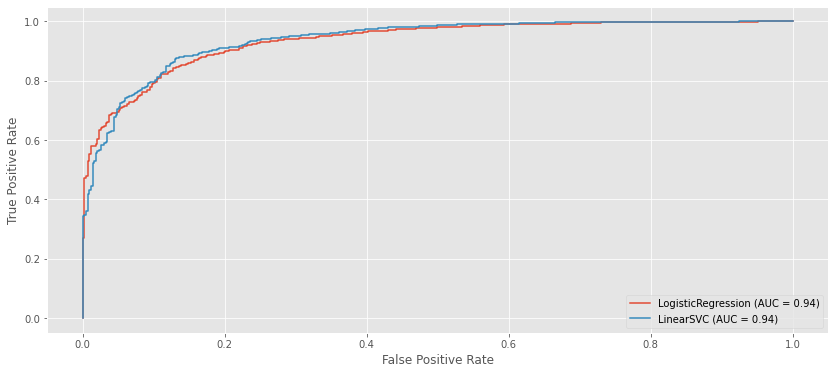

<Figure size 288x576 with 0 Axes>

In [49]:
import matplotlib.pyplot as plt  
from sklearn import datasets, metrics, model_selection, svm


lr_model_all_new.fit(X_train_tfidf, y_train_tfidf)

log_disp2 = metrics.plot_roc_curve(lr_model_all_new, X_test_tfidf, y_test_tfidf) 
clf_disp2 = metrics.plot_roc_curve(clf_model_all_new, X_test_tfidf, y_test_tfidf, ax = log_disp2.ax_)

clf_disp.figure_.suptitle("ROC curve comparison")
plt.figure(figsize=(4,8))
plt.show()

ROC Curve comparison shows that the area under curve for SVC Classifier and LR both are the same and it means both models have almost the same performance. Looking at the f1-scores of these models, we can see that the SVC model has a higher score than LR (94.9% vs 93.6%). So, by using f1-scores SVC has higher accuracy than LR.

In general, for imbalanced classification with a severe skew and few examples of the minority class, the ROC AUC can be misleading. This is because a small number of correct or incorrect predictions can result in a large change in the ROC Curve or ROC AUC score.

### <a id='Word-Embeddings-Model'>7.3. Word Embeddings Model</a> 

Word embeddings is a type of word representation that allows words with similar meaning to have a similar representation. Word embeddings are in fact a class of techniques where individual words are represented as real-valued vectors in a predefined vector space.

In the following image, each of the words have been represented in 2-dimensions for simplicity. It can be clearly seen that words with similar context are grouped together.

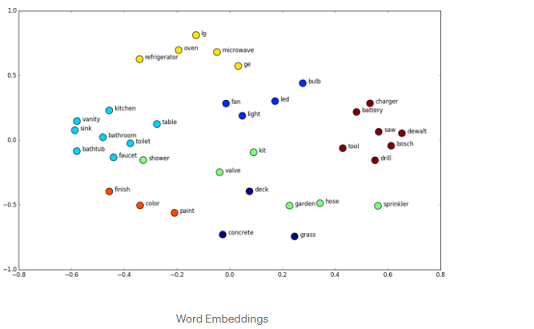

In [153]:
from IPython.display import Image
from IPython.core.display import HTML

Each word is represented by a real-valued vector, which generally has tens or hundreds of dimensions. This is in contrast to the thousands or millions of dimensions required for sparse word representations. Thus, word embeddings can drastically reduce the number of dimensions required for representing a text document.

In [154]:
# importing genism which is designed to handle large text collections using data streaming and incremental online algorithms
import gensim   # a topic-modelling and vector space modelling toolkit

We will be working with a pre-trained word2vec model from twitter (available at: https://drive.google.com/file/d/1GpHOJv3QXHcpTXfC0q-xwkPrVrjWeM1d/view).

In this notebook we are not going to execute FastText modeling because it's going to take a long time to finish, but we are going to use a pre-trained Twitter Glove pretrained model which contains a lot of words represented in a 200 dimension with space. So, both generate the exact same results. Basically we are loading the twitter glove pre-trained model which contains 200 features per word and we are going to use that model in order to transform our reviews to that 200 feature spaces. Here we show some examples. For example the word food has 200 feature representations. So, every word has 200 features and we might want to process those words in our reviews of Amazon.       

In [155]:
# Loading a pre-trained glove word embedding that is trained on twitter dataset 
# This word embedding is 200 dimensional in lenght (200 features per term)
# Source: https://nlp.stanford.edu/projects/glove/

model = gensim.models.KeyedVectors.load_word2vec_format(
    os.path.join(os.getcwd(),'Twitter_Glove_pretrained.txt'),
    binary=False,
    unicode_errors='ignore')

The following modeling reduces 18037 features to 200. To generate a model like the one we are importing, we can uncomment and execute the following commented code cell below and execute it. The computational expense might take more than 2h processing. 

In [156]:
#from gensim.models.fasttext import FastText

# Set values for various parameters
# feature_size = 200   # Word vector dimensionality  
# min_word_count = 1   # Minimum word count                        
# sample = 1e-3        # Downsample setting for frequent words
# iter = 5000          # Represents the number of epochs

# tokenized_corpus = [nltk.word_tokenize(doc) for doc in amazon_ProRev['lowercase_text_reviews']]
# ft_model = FastText(tokenized_corpus, size=feature_size, 
#                      min_count = min_word_count, sample=sample, 
#                      iter=5000)

# ft_model.save_model("model_filename.bin") # Saving the model
# model = fasttext.load_model("model_filename.bin") # Loading the model

We had approximately 18037 distinct tokens for 1-gram features in the bag-of-words representation, yet will only have 200 dimensions in this word embedding. This is a huge difference! Moreover, word embeddings capture the context and semantics of the sentences since each word vector representation is itself based on its contextual meaning.
Below shows two vector representations for the two example words, "food" and "great". They have one dimensional vector and 200 feature representations. So, every word has 200 features and we process those words in the reviews of Amazon.

In [157]:
print("The embedding for food is", len(model['food']), "dimensional")
model['food']

The embedding for food is 200 dimensional


array([-6.9175e-01, -1.4259e-01,  3.8653e-01, -2.3141e-01, -2.0408e-01,
       -2.1565e-01,  7.7839e-01,  2.2689e-03, -7.2446e-02, -6.0134e-01,
       -4.2400e-01, -5.7140e-01, -8.4249e-01,  1.5947e-01, -1.2899e-01,
        5.9032e-01, -1.3632e-01, -6.6478e-01, -1.9557e-01, -8.2453e-01,
       -1.3177e-01,  1.3514e-01, -7.3214e-01,  4.8200e-01,  4.3505e-01,
        1.6676e+00, -1.8275e-01, -1.0007e-01,  3.7003e-01,  1.0411e-01,
       -8.8115e-01, -9.7733e-04, -2.9459e-01, -7.3869e-02, -4.0103e-01,
       -4.6626e-01,  2.3253e-01,  2.7776e-01,  4.0754e-01, -4.5051e-02,
       -1.9468e-01, -2.9230e-01, -3.4642e-01, -4.9286e-01,  1.0467e-01,
        7.2143e-01,  5.9596e-01,  5.3495e-01,  3.8788e-02, -1.4406e-01,
       -5.2248e-02, -6.8292e-01, -1.0080e-01, -1.2961e-01, -2.6006e-02,
        1.4836e-01,  3.2417e-02,  1.3997e-01,  8.3943e-03, -2.3139e-01,
       -1.8000e-01, -3.1689e-01,  2.3606e-01,  1.8237e-01,  4.3933e-01,
       -3.2313e-01, -2.1512e-03, -4.4172e-01,  4.1011e-01,  1.71

In [158]:
print("The embedding for great is", len(model['great']), "dimensional")
model['great']

The embedding for great is 200 dimensional


array([ 1.0751e-01,  1.5958e-01,  1.3332e-01,  1.6642e-01, -3.2737e-02,
        1.7592e-01,  7.2395e-01,  1.1713e-01, -3.5036e-01, -4.2937e-01,
       -4.0925e-01, -2.5761e-01, -1.0264e+00, -1.0014e-01,  5.5390e-02,
        2.0413e-01,  1.2807e-01, -2.6337e-02, -6.9719e-02, -3.6193e-02,
       -1.9917e-01,  3.9437e-02, -9.2358e-02,  2.6981e-01, -2.0951e-01,
        1.5455e+00, -2.8123e-01,  3.2046e-01,  4.5545e-01, -3.8841e-02,
       -1.7369e-01, -2.3251e-01, -5.9551e-02,  2.3250e-01,  4.4214e-01,
        3.3666e-01,  3.9352e-02, -1.2462e-01, -2.9317e-01, -4.8857e-02,
        6.9021e-01,  7.1279e-02,  1.0252e-01,  1.6122e-01, -2.3536e-01,
        6.2724e-02,  2.0222e-01,  5.0234e-02, -1.1611e-01,  2.8909e-02,
       -1.1109e-01, -5.0241e-02, -5.9063e-01, -8.8747e-02,  5.1444e-01,
       -1.3715e-01,  1.7194e-01, -8.3657e-02,  9.6333e-02, -9.7063e-02,
        3.4003e-03, -7.0180e-02, -5.9588e-01, -2.8264e-01,  1.2529e-01,
        2.4359e-01, -4.9082e-01, -4.2533e-02,  2.2158e-01, -2.14

To find the vector for an entire review, we get the vector for each word in the review separately and take a simple average.
Here we are joining that pre-trained model and that word presentation to our reviews, so we can have 200 features per observation per review. 

Now we calculate the vector for every single review in the dataset.

In [159]:
# List for adding each average rperesentation per observation
review_embeddings = []

# Review_average
Review_average = np.zeros(model.vector_size)

# For each review in the review's dataset
for each_review in amazon_ProRev['lowercase_text_reviews']:
     count_val = 0
     # For each worn in the review
     for each_word in word_tokenize(each_review):     
        if(each_word.lower() in model):
            Review_average += model[each_word.lower()]
            count_val += 1
    
     review_embeddings.append(list(Review_average/count_val))

Let's convert the list of vector representations for each review into a DataFrame and split it into train and test sets.

In [160]:
# Converting to a DataFrame object
embedding_data = pd.DataFrame(review_embeddings)

# Filling null values
# Null values are the ones that the Twitter pre-trained model is not considering (few of them)
embedding_data = embedding_data.fillna(0)
embedding_data

,0,1,2,3,4,5,6,7,8,9,...,190,191,192,193,194,195,196,197,198,199
0,0.017031,0.073933,0.044372,0.345686,-0.054879,0.128388,0.516738,-0.051841,-0.170889,-0.215053,...,-0.148464,0.069972,0.180464,0.072243,0.058429,-0.042165,0.102130,0.102651,-0.027328,0.045897
1,0.004867,0.234855,0.081459,0.800303,-0.175189,0.491553,1.240453,-0.123022,-0.152865,-0.495640,...,-0.294793,0.156971,0.302243,0.136332,0.077925,-0.178687,0.319638,0.329597,-0.010736,-0.045276
2,0.054898,0.121937,0.086319,0.452975,-0.100278,0.330602,0.828519,-0.135867,-0.220501,-0.445102,...,-0.252651,0.168930,0.193142,0.118796,0.071619,-0.202528,0.298770,0.185984,-0.064427,-0.042747
3,0.121080,0.415778,0.208763,1.150782,-0.285192,0.832986,2.195385,-0.337402,-0.621329,-1.226587,...,-0.687255,0.431361,0.537418,0.322497,0.098490,-0.426390,0.690071,0.534326,-0.124685,-0.199035
4,0.197436,0.701286,0.429690,1.899491,-0.479943,1.313881,3.710398,-0.582405,-1.249420,-2.059263,...,-1.146727,0.863788,1.067669,0.384649,0.358384,-0.715020,1.157039,0.889476,-0.126488,-0.355712
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9132,-135.118570,1603.391175,1200.402073,4043.776319,-1366.831029,3431.140242,12165.270690,-1998.605435,-2829.955799,-4764.436293,...,-3268.179717,1600.835113,2345.339643,210.649013,441.870109,-1540.166664,2897.978371,3552.874055,-443.047627,-239.530057
9133,-46.262026,549.113219,411.154716,1384.951148,-468.010915,1175.151251,4166.656854,-684.511448,-969.302577,-1631.833533,...,-1119.288914,548.180227,803.262467,72.233662,151.366317,-527.599798,992.601517,1216.900516,-151.632963,-82.007893
9134,-40.695678,482.963213,361.680872,1218.239158,-411.665424,1033.726995,3665.057244,-602.113941,-852.594775,-1435.428782,...,-984.518924,482.161553,706.629380,63.624305,133.097164,-464.049121,873.125890,1070.432422,-133.306181,-72.186908
9135,-19.798611,235.852405,176.647535,594.976721,-201.029682,504.821211,1789.863001,-294.001505,-416.384191,-701.022258,...,-480.786358,235.451227,345.113985,31.071044,64.990887,-226.635431,426.379239,522.786156,-65.121339,-35.257320


Now we can implement a classifier for the model. 

### <a id='Applying-Logistic-Regression-to-Word-Embeddings-Features'>7.3.1. Applying Logistic Regression to Word Embeddings Features </a> 


In [161]:
X_train_embed, X_test_embed, y_train_embed, y_test_embed = train_test_split(embedding_data, 
                                                                            amazon_ProRev['Sentiment_rating'],  # Target variable
                                                                            test_size = 0.2,
                                                                            random_state = 0)

Applying logistic regression to our word embeddings representation.

In [162]:
lr_model_all.fit(X_train_embed, y_train_embed)
test_pred_lr_all = lr_model_all.predict(X_test_embed)

print("f1 score: ",f1_score(y_test_embed, test_pred_lr_all))

f1 score:  0.916098428698488


As we see the f1 score here is lower than the scores for BOW and TF_IDF using the Logistic Regression method, but we have to note that we're reducing 18037 features to 200 which is a lot of reduction in the feature space which affects on the model performance. In contrast the computational expenses are going to greatly decrease. In general the approach that we follow in this notebook is to build a model based on the features and then we do the prediction using other reviews and predict the sentiment of the user. So, if another review will be posted we can predict with a 91.6% of f1 score what its sentiment is, if it's positive or negative against the product.

### <a id='Applying-Linear-Support-Vector-Machine-(SVM)-to-Word-Embeddings-Features'>7.3.2.  Applying Linear Support Vector Machine to Word Embeddings (SVM) Features</a>  

In [163]:
from sklearn.svm import LinearSVC
from sklearn.metrics import classification_report

clf_model_all_new = LinearSVC(C= 20)
clf_model_all_new.fit(X_train_embed, y_train_embed)

LinearSVC(C=20, class_weight=None, dual=True, fit_intercept=True,
          intercept_scaling=1, loss='squared_hinge', max_iter=1000,
          multi_class='ovr', penalty='l2', random_state=None, tol=0.0001,
          verbose=0)

In [164]:
test_pred_clf_all = clf_model_all_new.predict(X_test_embed)

print("f1 score: ", f1_score(y_test_embed,test_pred_clf_all))

f1 score:  0.8931390406800243


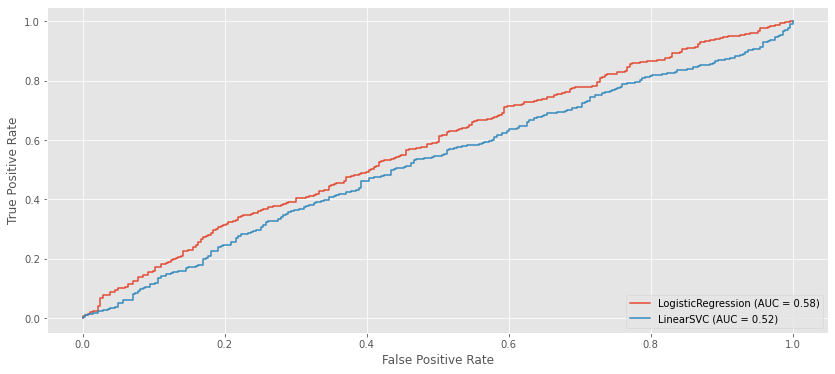

<Figure size 288x576 with 0 Axes>

In [165]:
import matplotlib.pyplot as plt  
from sklearn import datasets, metrics, model_selection, svm


lr_model_all_new.fit(X_train_embed, y_train_embed)

log_disp2 = metrics.plot_roc_curve(lr_model_all_new, X_test_embed, y_test_embed) 
clf_disp2 = metrics.plot_roc_curve(clf_model_all_new, X_test_embed, y_test_embed, ax = log_disp2.ax_)

clf_disp.figure_.suptitle("ROC curve comparison")
plt.figure(figsize=(4,8))
plt.show()

ROC Curve comparison shows that the area under curve for LR Classifier (0.58) is bigger than SVM (0.52) and as result it has higher performance.

### <a id='Summary-and-Conclusion'>8. Summary and Conclusion</a> 

The analysis of the language components through Natural Language Processing (NLP) allows us to make decisions in various spectra, among which we can highlight marketing, advertising, communication and social networks.

In this study, we cleaned up and featurized an Amazon reviews dataset and built some classification models on these featurizations to predict sentiment. Three major steps of text data analyzing that were used are: 
- Vectorizing process, which converted the text data into a numerical feature vector by splitting it into words or tokens. 
- Transforming process to find the occurrence of each word in a document. This process is primarily used for feature extraction. 
- Classifier or model training for accurate predictions. The model used training and testing dataset to optimize its overall performance.
 
Building machine learning models on text is a very involved discipline. Some important things of note are as follows:
 
- Although there are different types of pre-processing involved in textual data, not everything has to be applied in each case. For instance, when dealing with text messages special characters might represent important information and need not be removed. Furthermore, upper case may mean someone is angry and represents shouting, so this case may not need to be normalized either.
- Hyperparameter tuning in machine learning models is a very important step. We can't go ahead training a model with default parameters. Different sets of parameters have to be tried to see what contributes to the best model.
- Every NLP classification task is different, but the process to be followed is similar to what we did in this case, working on data → create features from text → train ML models.
 
The results show that bag-of-words and TF-IDF both gave interpretable features, while word embeddings did not really. Through increasing the set of n-grams we used from 1-grams to up to 3-grams, we were able to get our Logistic Regression model accuracy up to 95.2% and Support Vector Machine up to 95.6%. The procedure explained in this notebook can be extrapolated for all types of NLP studies in which text data records are kept, can provide great information on customer patterns and business analysis.
 
By comparing three models (bag-of-words, TF-IDF and word-embeddings) Word Embeddings model did not perform as good as either the bag-of-words or TF-IDF representations, using both Logistic Regression and Linear Support Vector Machine Algorithms. Furthermore, although Word Embeddings were really effective at reducing the overall number of dimensions, it suffers from the problem of interpretability. This means that it is very hard for us to even diagnose what is causing its sub-par performance. Creating features using TF-IDF got us an accuracy of 95.6% with very interpretable features using SVM method. This is a good combination and so we deem this the best model for us here. 

Comparing the three featured models using LR and SVM also shows that SVC had higher accuracy than LR in bag-of-words and TF_IDF and in Word Embeddings the SVM had higher accuracy than LR.

In the future research we can try using a tree based classifier ensemble to capture non-linearity and interactions between the features such as random forest. Related to the cleaning text we can also do more detailed processing such as remove hyperlinks, remove typo words, ...
